<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 
    
    
### <font color='navy'> Simulación de procesos financieros. 

**Nombres:** Gerardo González y Xareny Gonzalez 

**Fecha:**  27 de noviembre del 2021.

**Expediente** : 721430 y 720811
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: https://github.com/gerardogonz/Tarea9_GonzalezGerardo_GonzalezXareny

# Tarea 9: Clase 23

Implementar el método de esquemas del trapecio, para valuar la opción call y put asiática con precio inicial, $S_0 = 100$, precio de ejercicio $K = 100$, tasa libre de riesgo $r = 0.10$, volatilidad $\sigma = 0.20$ y $T = 1$ año. Cuyo precio es $\approx 7.04$. Realizar la simulación en base a la siguiente tabla:
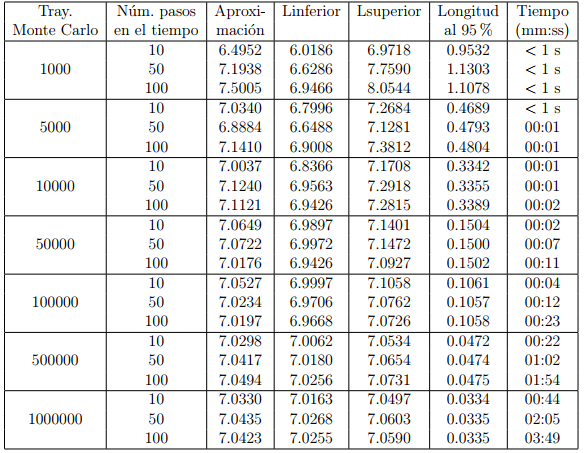

Observe que en esta tabla se encuentran los intervalos de confianza de la aproximación obtenida y además el tiempo de simulación que tarda en encontrar la respuesta cada método. 
- Se debe entonces realizar una simulación para la misma cantidad de trayectorias y número de pasos y construir una Dataframe de pandas para reportar todos los resultados obtenidos.**(70 puntos)**
- Compare los resultados obtenidos con los resultados arrojados por la función `Riemann_approach`. Concluya. **(30 puntos)**


# Estudiante 1: Gerardo González 



In [1]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import datetime
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import time
%matplotlib inline

# Algunas opciones para Pandas.
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 9)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

In [2]:
def BSprices(mu,sigma,S0,NbTraj,NbStep):
    """
    Expresión de la solución de la ecuación de Black-Scholes
    St = S0*exp((r-sigma^2/2)*t+ sigma*DeltaW)
    
    Parámetros
    ---------
    mu    : Tasa libre de riesgo
    sigma : Desviación estándar de los rendimientos
    S0    : Precio inicial del activo subyacente
    NbTraj: Cantidad de trayectorias a simular
    NbStep: Número de días a simular
    """
    # Datos para la fórmula de St
    nu = mu-(sigma**2)/2
    DeltaT = 1/NbStep
    SqDeltaT = np.sqrt(DeltaT)
    DeltaW = SqDeltaT*np.random.randn(NbTraj,NbStep-1)
    
    # Se obtiene --> Ln St = Ln S0+ nu*DeltaT + sigma*DeltaW
    increments = nu*DeltaT + sigma*DeltaW
    concat = np.concatenate((np.log(S0)*np.ones([NbTraj,1]),increments),axis=1)
    
    # Se utiliza cumsum por que se quiere simular los precios iniciando desde S0
    LogSt = np.cumsum(concat,axis=1)
    # Se obtienen los precios simulados para los NbStep fijados
    St = np.exp(LogSt)
    # Vector con la cantidad de días simulados
    t = np.arange(0,NbStep)

    return St.T,t

In [3]:
def Riemann_approach(K:'Strike price',
                     r:'Tasa libre de riesgo',
                     S0:'Precio inicial',
                     NbTraj:'Número trayectorias',
                     NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad',T:'Tiempo de cierre del contrato en años',
                     Option_Type: 'Tipo de opción a valuar. Call o Put.',
                     Trust_level: 'Confianza definida para el intervalo de precios',
                     flag=None):
    # Definimos tiempo de ejecución
    start = time.time()
    
    # Resolvemos la ecuación de black scholes para obtener los precios
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    # Almacenamos los precios en un dataframe
    prices = pd.DataFrame(St,index=t)
    # Obtenemos los precios promedios
    Average_t = prices.expanding().mean()
    # Definimos el dataframe de strikes
    strike = K
    
    if Option_Type in ['Call', 'call']:
        # Calculamos el call de la opción según la formula obtenida para Sumas de Riemann
        call = pd.DataFrame({'Prima': np.exp(-r*T) \
                     *np.fmax(Average_t - strike, 0).mean(axis=1)}, index=t)
        # Intervalo de confianza
        sigma_est_call = call.sem().Prima
        mean_est_call = call.iloc[-1].Prima
        i1_call = st.norm.interval(Trust_level, loc=mean_est_call, scale=sigma_est_call)
        
        end_c = time.time()
        total_time_c = end_c - start

        return call.iloc[-1].Prima, i1_call[0], i1_call[1], i1_call[1] - i1_call[0], total_time_c
    
    else:
        # Calculamos el put de la opción según la formula obtenida para Sumas de Riemann
        put = pd.DataFrame({'Prima': np.exp(-r*T) \
                     *np.fmax(strike - Average_t, 0).mean(axis=1)}, index=t)
        # Intervalo de confianza
        sigma_est_put = put.sem().Prima
        mean_est_put = put.iloc[-1].Prima
        i1_put = st.norm.interval(Trust_level, loc=mean_est_put, scale=sigma_est_put)
        
        end_p = time.time()
        total_time_p = end_p - start

        return put.iloc[-1].Prima, i1_put[0], i1_put[1], i1_put[1] - i1_put[0], total_time_p

In [4]:
def Trapeze_approach(K:'Strike price',
                     r:'Tasa libre de riesgo',
                     S0:'Precio inicial',
                     NbTraj:'Número trayectorias',
                     NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad',T:'Tiempo de cierre del contrato en años',
                     Option_Type: 'Tipo de opción a valuar. Call o Put.',
                     Trust_level: 'Confianza definida para el intervalo de precios',
                     flag=None):
    # Definimos tiempo de ejecución
    start = time.time()
    
    # Resolvemos la ecuación de black scholes para obtener los precios
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    # Almacenamos los precios en un dataframe
    prices = pd.DataFrame(St,index=t)
    # Definimos la longitud h
    h = T / NbStep
    # Definimos el dataframe de strikes
    strike = K
    
    if Option_Type in ['Call', 'call']:
        # Definimos el trapecio para el call
        Average_trapeze_c = (prices * (2 + (r*h) + ((np.random.randn(NbStep, NbTraj)) * sigma))).expanding().sum()
        
        # Calculamos el call de la opción según la formula obtenida para el trapecio
        call = pd.DataFrame({'Prima': np.exp(-r*T) \
                     *np.fmax((h/2*T) * Average_trapeze_c - strike, 0).mean(axis=1)}, index=t)
        # Intervalo de confianza
        sigma_est_call = call.sem().Prima
        mean_est_call = call.iloc[-1].Prima
        i1_call = st.norm.interval(Trust_level, loc=mean_est_call, scale=sigma_est_call)
        end_c = time.time()
        total_time_c = end_c - start

        return call.iloc[-1].Prima, i1_call[0], i1_call[1], i1_call[1] - i1_call[0], total_time_c
    
    else:
        # Definimos el trapecio para el put
        Average_trapeze_p = (prices * (2 + (r*h) + ((np.random.randn(NbStep, NbTraj)) * sigma))).expanding().sum()
        
        # Calculamos el put de la opción según la formula obtenida para el trapecio
        put = pd.DataFrame({'Prima': np.exp(-r*T) \
                     *np.fmax(strike - (h/2*T) * Average_trapeze_p, 0).mean(axis=1)}, index=t)
        # Intervalo de confianza
        sigma_est_put = put.sem().Prima
        mean_est_put = put.iloc[-1].Prima
        i1_put = st.norm.interval(Trust_level, loc=mean_est_put, scale=sigma_est_put)
        
        end_p = time.time()
        total_time_p = end_p - start
    
        return put.iloc[-1].Prima, i1_put[0], i1_put[1], i1_put[1] - i1_put[0], total_time_p

In [5]:
# Parametros.
Nt = [1000] * 3 + [5000] * 3 + [10000] * 3 + [50000] * 3 + [100000] * 3 + [500000] * 3 +  [1000000] * 3
Ns = [10, 50, 100] * len(set(Nt))
index = [Nt, Ns]

# Valores de la opción.
S0 = 100
K = 100
r = 0.10
sigma = 0.20
T = 1

In [6]:
# Definimos simulación                              
Nt_sim = [1000, 5000, 10000, 50000, 100000, 500000, 1000000]
Ns_sim = [10, 50, 100]
sr_call = [[Riemann_approach(K, r, S0, j, i, sigma, T, 'Call', 0.95) for i in Ns_sim] for j in Nt_sim]


In [7]:
def valores(sim_vector):
    
 
    T1 = ([np.array(sim_vector[i]) for i in range(len(sim_vector))][0])
    T2 = ([np.array(sim_vector[i]) for i in range(len(sim_vector))][1])
    T3 = ([np.array(sim_vector[i]) for i in range(len(sim_vector))][2])
    T4 = ([np.array(sim_vector[i]) for i in range(len(sim_vector))][3])
    T5 = ([np.array(sim_vector[i]) for i in range(len(sim_vector))][4])
    T6 = ([np.array(sim_vector[i]) for i in range(len(sim_vector))][5])
    T7 = ([np.array(sim_vector[i]) for i in range(len(sim_vector))][6])


    matriz = np.concatenate([T1, T2, T3, T4, T5, T6, T7])
    
    return matriz

In [8]:
callRim = pd.DataFrame(valores(sr_call),
                                 columns=['Aproximación', 'Linferior', 'Lsuperior', 'Longitud al 95%', 'Tiempo'],
                                 index=pd.MultiIndex.from_arrays(index, names=('T. Montecarlo', 'N. pasos en el tiempo')))
callRim

Aproximación  Linferior  Lsuperior  \
T. Montecarlo N. pasos en el tiempo                                       
1000          10                            6.728      5.391      8.065   
              50                            7.120      6.597      7.644   
              100                           6.680      6.339      7.021   
5000          10                            6.378      5.109      7.648   
              50                            6.997      6.473      7.521   
...                                           ...        ...        ...   
500000        50                            6.907      6.391      7.422   
              100                           6.962      6.604      7.321   
1000000       10                            6.424      5.151      7.698   
              50                            6.917      6.401      7.434   
              100                           6.988      6.628      7.349   

                                     Longitud al 95%  Tiempo  
T. Montecarlo N. pasos en el tiempo                           
1000          10                               2.675   0.075  
              50                               1.047   0.048  
              100                              0.682   0.034  
5000          10                               2.539   0.094  
              50                               1.048   0.123  
...                                              ...     ...  
500000        50                               1.031  16.123  
              100                              0.717  24.376  
1000000       10                               2.547  19.714  
              50                               1.033  28.774  
              100                              0.721  62.452  

[21 rows x 5 columns]

In [9]:
st_call = [[Trapeze_approach(K, r, S0, j, i, sigma, T, 'Call', 0.95) for i in Ns_sim] for j in Nt_sim]

In [10]:
callTrap = pd.DataFrame(valores(st_call),
                                 columns=['Aproximación', 'Linferior', 'Lsuperior', 'Longitud al 95%', 'Tiempo'],
                                 index=pd.MultiIndex.from_arrays(index, names=('T. Montecarlo', 'N. pasos en el tiempo')))
callTrap

Aproximación  Linferior  Lsuperior  \
T. Montecarlo N. pasos en el tiempo                                       
1000          10                            6.745      5.421      8.069   
              50                            6.746      6.353      7.139   
              100                           6.926      6.653      7.199   
5000          10                            6.849      5.505      8.193   
              50                            7.070      6.652      7.488   
...                                           ...        ...        ...   
500000        50                            7.012      6.598      7.426   
              100                           7.021      6.745      7.297   
1000000       10                            6.884      5.534      8.234   
              50                            7.023      6.608      7.437   
              100                           7.030      6.753      7.306   

                                     Longitud al 95%  Tiempo  
T. Montecarlo N. pasos en el tiempo                           
1000          10                               2.648   0.039  
              50                               0.786   0.046  
              100                              0.547   0.044  
5000          10                               2.688   0.122  
              50                               0.836   0.159  
...                                              ...     ...  
500000        50                               0.828  15.312  
              100                              0.552  20.391  
1000000       10                               2.700  18.029  
              50                               0.830  27.338  
              100                              0.553  72.570  

[21 rows x 5 columns]

In [11]:
sr_put = [[Riemann_approach(K, r, S0, j, i, sigma, T, 'Put', 0.95) for i in Ns_sim] for j in Nt_sim]

In [12]:
putRim = pd.DataFrame(valores(sr_put),
                                 columns=['Aproximación', 'Linferior', 'Lsuperior', 'Longitud al 95%', 'Tiempo'],
                                 index=pd.MultiIndex.from_arrays(index, names=('T. Montecarlo', 'N. pasos en el tiempo')))
putRim

Aproximación  Linferior  Lsuperior  \
T. Montecarlo N. pasos en el tiempo                                       
1000          10                            2.258      1.816      2.701   
              50                            2.605      2.434      2.775   
              100                           2.365      2.266      2.463   
5000          10                            2.219      1.794      2.644   
              50                            2.164      2.031      2.298   
...                                           ...        ...        ...   
500000        50                            2.333      2.185      2.481   
              100                           2.353      2.253      2.453   
1000000       10                            2.222      1.796      2.648   
              50                            2.331      2.183      2.479   
              100                           2.345      2.245      2.444   

                                     Longitud al 95%  Tiempo  
T. Montecarlo N. pasos en el tiempo                           
1000          10                               0.885   0.038  
              50                               0.341   0.033  
              100                              0.197   0.033  
5000          10                               0.850   0.098  
              50                               0.267   0.115  
...                                              ...     ...  
500000        50                               0.296  17.150  
              100                              0.200  23.008  
1000000       10                               0.852  20.354  
              50                               0.296  32.363  
              100                              0.200  70.640  

[21 rows x 5 columns]

In [13]:
st_put = [[Trapeze_approach(K, r, S0, j, i, sigma, T, 'Put', 0.95) for i in Ns_sim] for j in Nt_sim]

In [14]:
putTrap = pd.DataFrame(valores(st_put),
                                 columns=['Aproximación', 'Linferior', 'Lsuperior', 'Longitud al 95%', 'Tiempo'],
                                 index=pd.MultiIndex.from_arrays(index, names=('T. Montecarlo', 'N. pasos en el tiempo')))
putTrap

Aproximación  Linferior  Lsuperior  \
T. Montecarlo N. pasos en el tiempo                                       
1000          10                            2.180    -14.942     19.302   
              50                            2.443     -4.997      9.884   
              100                           2.330     -2.928      7.589   
5000          10                            2.322    -14.771     19.415   
              50                            2.333     -5.136      9.803   
...                                           ...        ...        ...   
500000        50                            2.329     -5.134      9.792   
              100                           2.341     -2.917      7.600   
1000000       10                            2.229    -14.887     19.346   
              50                            2.333     -5.129      9.795   
              100                           2.343     -2.915      7.600   

                                     Longitud al 95%  Tiempo  
T. Montecarlo N. pasos en el tiempo                           
1000          10                              34.244   0.058  
              50                              14.881   0.037  
              100                             10.516   0.039  
5000          10                              34.187   0.094  
              50                              14.938   0.124  
...                                              ...     ...  
500000        50                              14.926  14.933  
              100                             10.516  20.698  
1000000       10                              34.233  20.686  
              50                              14.924  33.665  
              100                             10.516  76.953  

[21 rows x 5 columns]

A pesar de que los resultados son bastante similares entre ambos métodos es bueno mencionar que el codigo fue mas rapido en el del trapecio por lo que consideramos resultaria un mejor método a considerar

# Estudiante 2: Xareny González

In [3]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import datetime
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import time
%matplotlib inline

# Algunas opciones para Pandas.
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 9)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

In [4]:
def BSprices(mu,sigma,S0,NbTraj,NbStep):
    """
    Expresión de la solución de la ecuación de Black-Scholes
    St = S0*exp((r-sigma^2/2)*t+ sigma*DeltaW)
    
    Parámetros
    ---------
    mu    : Tasa libre de riesgo
    sigma : Desviación estándar de los rendimientos
    S0    : Precio inicial del activo subyacente
    NbTraj: Cantidad de trayectorias a simular
    NbStep: Número de días a simular
    """
    # Datos para la fórmula de St
    nu = mu-(sigma**2)/2
    DeltaT = 1/NbStep
    SqDeltaT = np.sqrt(DeltaT)
    DeltaW = SqDeltaT*np.random.randn(NbTraj,NbStep-1)
    
    # Se obtiene --> Ln St = Ln S0+ nu*DeltaT + sigma*DeltaW
    increments = nu*DeltaT + sigma*DeltaW
    concat = np.concatenate((np.log(S0)*np.ones([NbTraj,1]),increments),axis=1)
    
    # Se utiliza cumsum por que se quiere simular los precios iniciando desde S0
    LogSt = np.cumsum(concat,axis=1)
    # Se obtienen los precios simulados para los NbStep fijados
    St = np.exp(LogSt)
    # Vector con la cantidad de días simulados
    t = np.arange(0,NbStep)

    return St.T,t

In [5]:
def Riemann_approach(K:'Strike price',
                     r:'Tasa libre de riesgo',
                     S0:'Precio inicial',
                     NbTraj:'Número trayectorias',
                     NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad',T:'Tiempo de cierre del contrato en años',
                     Option_Type: 'Tipo de opción a valuar. Call o Put.',
                     Trust_level: 'Confianza definida para el intervalo de precios',
                     flag=None):
    # Definimos tiempo de ejecución
    start = time.time()
    
    # Resolvemos la ecuación de black scholes para obtener los precios
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    # Almacenamos los precios en un dataframe
    prices = pd.DataFrame(St,index=t)
    # Obtenemos los precios promedios
    Average_t = prices.expanding().mean()
    # Definimos el dataframe de strikes
    strike = K
    
    if Option_Type in ['Call', 'call']:
        # Calculamos el call de la opción según la formula obtenida para Sumas de Riemann
        call = pd.DataFrame({'Prima': np.exp(-r*T) \
                     *np.fmax(Average_t - strike, 0).mean(axis=1)}, index=t)
        # Intervalo de confianza
        sigma_est_call = call.sem().Prima
        mean_est_call = call.iloc[-1].Prima
        i1_call = st.norm.interval(Trust_level, loc=mean_est_call, scale=sigma_est_call)
        
        end_c = time.time()
        total_time_c = end_c - start

        return call.iloc[-1].Prima, i1_call[0], i1_call[1], i1_call[1] - i1_call[0], total_time_c
    
    else:
        # Calculamos el put de la opción según la formula obtenida para Sumas de Riemann
        put = pd.DataFrame({'Prima': np.exp(-r*T) \
                     *np.fmax(strike - Average_t, 0).mean(axis=1)}, index=t)
        # Intervalo de confianza
        sigma_est_put = put.sem().Prima
        mean_est_put = put.iloc[-1].Prima
        i1_put = st.norm.interval(Trust_level, loc=mean_est_put, scale=sigma_est_put)
        
        end_p = time.time()
        total_time_p = end_p - start

        return put.iloc[-1].Prima, i1_put[0], i1_put[1], i1_put[1] - i1_put[0], total_time_p

In [6]:
def Trapeze_approach(K:'Strike price',
                     r:'Tasa libre de riesgo',
                     S0:'Precio inicial',
                     NbTraj:'Número trayectorias',
                     NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad',T:'Tiempo de cierre del contrato en años',
                     Option_Type: 'Tipo de opción a valuar. Call o Put.',
                     Trust_level: 'Confianza definida para el intervalo de precios',
                     flag=None):
    # Definimos tiempo de ejecución
    start = time.time()
    
    # Resolvemos la ecuación de black scholes para obtener los precios
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    # Almacenamos los precios en un dataframe
    prices = pd.DataFrame(St,index=t)
    # Definimos la longitud h
    h = T / NbStep
    # Definimos el dataframe de strikes
    strike = K
    
    if Option_Type in ['Call', 'call']:
        # Definimos el trapecio para el call
        Average_trapeze_c = (prices * (2 + (r*h) + ((np.random.randn(NbStep, NbTraj)) * sigma))).expanding().sum()
        
        # Calculamos el call de la opción según la formula obtenida para el trapecio
        call = pd.DataFrame({'Prima': np.exp(-r*T) \
                     *np.fmax((h/2*T) * Average_trapeze_c - strike, 0).mean(axis=1)}, index=t)
        # Intervalo de confianza
        sigma_est_call = call.sem().Prima
        mean_est_call = call.iloc[-1].Prima
        i1_call = st.norm.interval(Trust_level, loc=mean_est_call, scale=sigma_est_call)
        end_c = time.time()
        total_time_c = end_c - start

        return call.iloc[-1].Prima, i1_call[0], i1_call[1], i1_call[1] - i1_call[0], total_time_c
    
    else:
        # Definimos el trapecio para el put
        Average_trapeze_p = (prices * (2 + (r*h) + ((np.random.randn(NbStep, NbTraj)) * sigma))).expanding().sum()
        
        # Calculamos el put de la opción según la formula obtenida para el trapecio
        put = pd.DataFrame({'Prima': np.exp(-r*T) \
                     *np.fmax(strike - (h/2*T) * Average_trapeze_p, 0).mean(axis=1)}, index=t)
        # Intervalo de confianza
        sigma_est_put = put.sem().Prima
        mean_est_put = put.iloc[-1].Prima
        i1_put = st.norm.interval(Trust_level, loc=mean_est_put, scale=sigma_est_put)
        
        end_p = time.time()
        total_time_p = end_p - start
    
        return put.iloc[-1].Prima, i1_put[0], i1_put[1], i1_put[1] - i1_put[0], total_time_p

### Call asiático 
####  Aproximación de Riemann

In [7]:
# Parametros.
Nt = [1000] * 3 + [5000] * 3 + [10000] * 3 + [50000] * 3 + [100000] * 3 + [500000] * 3 +  [1000000] * 3
Ns = [10, 50, 100] * len(set(Nt))
index = [Nt, Ns]

# Valores de la opción.
S0 = 100
K = 100
r = 0.10
sigma = 0.20
T = 1

In [11]:
# Definimos simulación                              
Nt_sim = [1000, 5000, 10000, 50000, 100000, 500000, 1000000]
Ns_sim = [10, 50, 100]
sr_call = [[Riemann_approach(K, r, S0, j, i, sigma, T, 'Call', 0.95) for i in Ns_sim] for j in Nt_sim]


In [12]:
def valores(sim_vector):
    
 
    T1 = ([np.array(sim_vector[i]) for i in range(len(sim_vector))][0])
    T2 = ([np.array(sim_vector[i]) for i in range(len(sim_vector))][1])
    T3 = ([np.array(sim_vector[i]) for i in range(len(sim_vector))][2])
    T4 = ([np.array(sim_vector[i]) for i in range(len(sim_vector))][3])
    T5 = ([np.array(sim_vector[i]) for i in range(len(sim_vector))][4])
    T6 = ([np.array(sim_vector[i]) for i in range(len(sim_vector))][5])
    T7 = ([np.array(sim_vector[i]) for i in range(len(sim_vector))][6])


    matriz = np.concatenate([T1, T2, T3, T4, T5, T6, T7])
    
    return matriz

In [16]:
callRim = pd.DataFrame(valores(sr_call),
                                 columns=['Aproximación', 'Linferior', 'Lsuperior', 'Longitud al 95%', 'Tiempo'],
                                 index=pd.MultiIndex.from_arrays(index, names=('T. Montecarlo', 'N. pasos en el tiempo')))
callRim

Aproximación  Linferior  Lsuperior  \
T. Montecarlo N. pasos en el tiempo                                       
1000          10                            6.713      5.369      8.058   
              50                            7.372      6.819      7.924   
              100                           7.096      6.735      7.457   
5000          10                            6.429      5.161      7.697   
              50                            6.786      6.280      7.293   
...                                           ...        ...        ...   
500000        50                            6.929      6.412      7.446   
              100                           6.960      6.602      7.319   
1000000       10                            6.421      5.148      7.695   
              50                            6.916      6.400      7.432   
              100                           6.966      6.607      7.325   

                                     Longitud al 95%  Tiempo  
T. Montecarlo N. pasos en el tiempo                           
1000          10                               2.689   0.037  
              50                               1.104   0.037  
              100                              0.723   0.034  
5000          10                               2.536   0.095  
              50                               1.013   0.131  
...                                              ...     ...  
500000        50                               1.035  12.872  
              100                              0.717  19.698  
1000000       10                               2.546  18.760  
              50                               1.032  25.987  
              100                              0.718  57.035  

[21 rows x 5 columns]

#### Método del Trapecio

In [14]:
                                         
st_call = [[Trapeze_approach(K, r, S0, j, i, sigma, T, 'Call', 0.95) for i in Ns_sim] for j in Nt_sim]

In [17]:
callTrap = pd.DataFrame(valores(st_call),
                                 columns=['Aproximación', 'Linferior', 'Lsuperior', 'Longitud al 95%', 'Tiempo'],
                                 index=pd.MultiIndex.from_arrays(index, names=('T. Montecarlo', 'N. pasos en el tiempo')))
callTrap

Aproximación  Linferior  Lsuperior  \
T. Montecarlo N. pasos en el tiempo                                       
1000          10                            6.726      5.408      8.045   
              50                            6.865      6.460      7.270   
              100                           7.005      6.733      7.277   
5000          10                            6.748      5.425      8.070   
              50                            7.139      6.719      7.560   
...                                           ...        ...        ...   
500000        50                            7.007      6.593      7.420   
              100                           7.039      6.762      7.316   
1000000       10                            6.897      5.544      8.250   
              50                            6.997      6.584      7.411   
              100                           7.033      6.756      7.309   

                                     Longitud al 95%  Tiempo  
T. Montecarlo N. pasos en el tiempo                           
1000          10                               2.636   0.039  
              50                               0.810   0.036  
              100                              0.545   0.037  
5000          10                               2.645   0.100  
              50                               0.841   0.128  
...                                              ...     ...  
500000        50                               0.827  15.919  
              100                              0.554  23.044  
1000000       10                               2.705  18.163  
              50                               0.826  28.633  
              100                              0.553  79.762  

[21 rows x 5 columns]

### Put asiático 
####  Aproximación de Riemann

In [18]:
                                      
sr_put = [[Riemann_approach(K, r, S0, j, i, sigma, T, 'Put', 0.95) for i in Ns_sim] for j in Nt_sim]

In [19]:
putRim = pd.DataFrame(valores(sr_put),
                                 columns=['Aproximación', 'Linferior', 'Lsuperior', 'Longitud al 95%', 'Tiempo'],
                                 index=pd.MultiIndex.from_arrays(index, names=('T. Montecarlo', 'N. pasos en el tiempo')))
putRim

Aproximación  Linferior  Lsuperior  \
T. Montecarlo N. pasos en el tiempo                                       
1000          10                            2.165      1.746      2.585   
              50                            2.529      2.364      2.694   
              100                           2.597      2.485      2.710   
5000          10                            2.282      1.840      2.724   
              50                            2.264      2.121      2.407   
...                                           ...        ...        ...   
500000        50                            2.338      2.189      2.486   
              100                           2.348      2.248      2.448   
1000000       10                            2.217      1.793      2.642   
              50                            2.331      2.183      2.479   
              100                           2.347      2.247      2.447   

                                     Longitud al 95%  Tiempo  
T. Montecarlo N. pasos en el tiempo                           
1000          10                               0.839   0.044  
              50                               0.331   0.032  
              100                              0.225   0.031  
5000          10                               0.884   0.093  
              50                               0.286   0.120  
...                                              ...     ...  
500000        50                               0.297  12.258  
              100                              0.200  19.434  
1000000       10                               0.850  18.554  
              50                               0.296  26.954  
              100                              0.200  56.596  

[21 rows x 5 columns]

#### Método del Trapecio

In [20]:
st_put = [[Trapeze_approach(K, r, S0, j, i, sigma, T, 'Put', 0.95) for i in Ns_sim] for j in Nt_sim]

In [21]:
putTrap = pd.DataFrame(valores(st_put),
                                 columns=['Aproximación', 'Linferior', 'Lsuperior', 'Longitud al 95%', 'Tiempo'],
                                 index=pd.MultiIndex.from_arrays(index, names=('T. Montecarlo', 'N. pasos en el tiempo')))
putTrap

Aproximación  Linferior  Lsuperior  \
T. Montecarlo N. pasos en el tiempo                                       
1000          10                            2.373    -14.691     19.437   
              50                            2.520     -4.892      9.932   
              100                           2.224     -3.041      7.490   
5000          10                            2.280    -14.820     19.381   
              50                            2.213     -5.266      9.691   
...                                           ...        ...        ...   
500000        50                            2.335     -5.126      9.797   
              100                           2.347     -2.911      7.605   
1000000       10                            2.229    -14.888     19.345   
              50                            2.330     -5.132      9.793   
              100                           2.344     -2.915      7.602   

                                     Longitud al 95%   Tiempo  
T. Montecarlo N. pasos en el tiempo                            
1000          10                              34.127    0.043  
              50                              14.824    0.034  
              100                             10.531    0.039  
5000          10                              34.202    0.097  
              50                              14.957    0.124  
...                                              ...      ...  
500000        50                              14.923   14.337  
              100                             10.516   21.101  
1000000       10                              34.233   19.877  
              50                              14.925   35.530  
              100                             10.517  109.741  

[21 rows x 5 columns]

### Conclusión
 > La diferencia que existe entre entre Riemann y el método del trapecio para las opciones de Put asiaticas es poca, sin embargo el del trapecio es un poco mejor en cuanto a la carga computacional. 
 
 > En general los resultados no muestran una diferencia significativa entre si por lo cual considero ambos métodos son buenos